# Convolution via Quadrature

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/Stheno.jl/blob/master/examples/quadrature-convolution/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/quadrature-convolution/).*

This example implements the convolution of a GP against the function ϕ(x) = exp(-x^2),
i.e.: (Lf)(x′) = ∫ ϕ(x′ - x) f(x) dx
It does this approximately using Gauss-Hermite quadrature, the implementation for which
is provided by FastGaussQuadrature.jl.
The implementation is limited to GPs whose index set is the real line.

In [1]:
using AbstractGPs
using AbstractGPsMakie
using CairoMakie
using FastGaussQuadrature
using KernelFunctions
using LaTeXStrings
using LinearAlgebra
using Literate
using Random
using Stheno

import AbstractGPs: AbstractGP, mean, cov, var

using CairoMakie: RGB
using Stheno: DerivedGP

## Define new affine transformation

The mean function is assumed to have zero-mean.
The cross-kernel (function of `x′`) is
`∫ ϕ(x′ - x) k(x, y) dx`,
and the kernel (function of `x′` and `y′`) is
`∫ ϕ(x′ - x) k(x, y) ϕ(y′ - y) dx dy`.

In [2]:
convolve(f::AbstractGP) = DerivedGP((convolve, f), f.gpc)

const conv_args = Tuple{typeof(convolve), AbstractGP}

mean((_, f)::conv_args, x::AbstractVector{<:Real}) = zeros(length(x))
cov(args::conv_args, x::AbstractVector{<:Real}) = cov(args, x, x)
var(args::conv_args, x::AbstractVector{<:Real}) = var(args, x, x)
function var(args::conv_args, x::AbstractVector{<:Real}, x′::AbstractVector{<:Real})
    return diag(cov(args, x, x′))
end

_quadrature(f, xs, ws) = sum(map((x, w) -> w * f(x), xs, ws))

function cov((_, f)::conv_args, x::AbstractVector{<:Real}, x′::AbstractVector{<:Real})

    num_points = 15
    xs, ws = gausshermite(num_points)

    cols_of_C = map(x′) do x′n
        col_elements = map(x) do xn
            _quadrature(
                x -> _quadrature(x′ -> only(cov(f, [xn - x], [x′n - x′])), xs, ws), xs, ws
            )
        end
    end
    return reduce(hcat, cols_of_C)
end

function cov(
    (_, f)::conv_args,
    f′::AbstractGP,
    x::AbstractVector{<:Real},
    x′::AbstractVector{<:Real},
)
    num_points = 15
    xs, ws = gausshermite(num_points)

    cols_of_C = map(x′) do x′n
        col_elements = map(x) do xn
            _quadrature(x -> only(cov(f, [xn - x], [x′n])), xs, ws)
        end
    end
    return reduce(hcat, cols_of_C)
end

function cov(
    f′::AbstractGP,
    args::conv_args,
    x::AbstractVector{<:Real},
    x′::AbstractVector{<:Real},
)
    return collect(transpose(cov(args, f′, x′, x)))
end

cov (generic function with 92 methods)

## Some plotting config

In [3]:
pt_per_unit() = 1

font_size() = 12

listing_font_size() = 10

page_width() = 6

size_from_inches(; height=4, width=4) = 72 .* (width, height)

set_theme!(font="Times")

function colours()
    return Dict(
        :blue => RGB(0/255, 107/255, 164/255),
        :cyan => RGB(75/255, 166/255, 251/255),
        :red => RGB(200/255, 82 / 255, 0 / 255),
        :pink => RGB(169/255, 90/255, 161/255),
        :black => RGB(0.0, 0.0, 0.0),
        :orange => RGB(245/255, 121/255, 58/255),
    )
end

shapes() = [:utriangle, :diamond, :square, :circle, :cross]

band_alpha() = 0.3
sample_alpha() = 0.2
point_alpha() = 1.0


function plot_band!(ax, x_plot, fx, colour, label)
    ms = marginals(fx)
    symband!(
        ax, x_plot, mean.(ms), std.(ms);
        bandscale=3,
        color=(colours()[colour], 0.5 * band_alpha()),
        label=label,
    )
end

function plot_sample!(ax, x_plot, fx, colour)
    gpsample!(
        ax, x_plot, fx;
        samples=4, color=(colours()[colour], sample_alpha()),
    )
end

function plot_gp!(ax, x_plot, fx, colour, label)
    plot_band!(ax, x_plot, fx, colour, label)
    plot_sample!(ax, x_plot, fx, colour)
end

plot_gp! (generic function with 1 method)

## Plot some stuff

Build a GPPP in which one GP is a convolution of the other, using the `convolve`
transformation defined above.

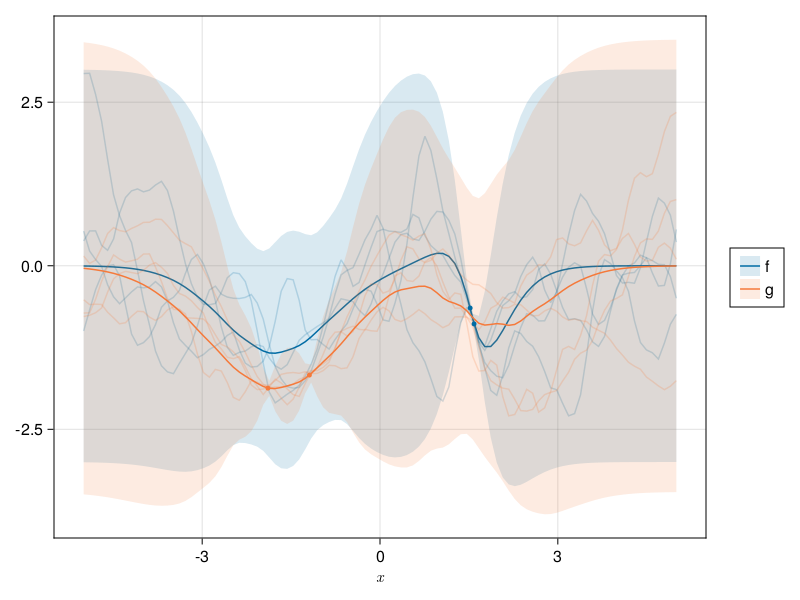

In [4]:
let
    f = @gppp let
        f = GP(with_lengthscale(Matern52Kernel(), 0.5))
        g = convolve(f)
    end

    rng = Xoshiro(123)
    x_f_obs = GPPPInput(:f, rand(rng, 2) .+ 1)
    x_g_obs = GPPPInput(:g, -rand(rng, 2) .- 1)
    x_obs = vcat(x_f_obs, x_g_obs)
    y = rand(Xoshiro(123), f(x_obs, 1e-3))
    y_f, y_g = split(x_obs, y)
    f_post = posterior(f(x_obs, 1e-3), y)

    x_plot = range(-5.0, 5.0; length=100)
    x_f = GPPPInput(:f, x_plot)
    x_g = GPPPInput(:g, x_plot)
    x = vcat(x_f, x_g)
    fig = Figure()

    # Plot posterior.
    ax = Axis(fig[1, 1]; xlabel=L"x")
    plot_gp!(ax, x_plot, f_post(x_f, 1e-6), :blue, "f")
    plot_gp!(ax, x_plot, f_post(x_g, 1e-6), :orange, "g")
    scatter!(ax, x_f_obs.x, y_f; color=colours()[:blue], markersize=7)
    scatter!(ax, x_g_obs.x, y_g; color=colours()[:orange], markersize=7)

    # Plot legend.
    Legend(fig[1, 2], ax; orientation=:vertical)

    fig
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*